In [1]:
import numpy as np
import os
import pandas as pd
data_path = os.getcwd() + '\\data\\'
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from nltk import word_tokenize
import matplotlib
from string import punctuation
from nltk.corpus  import stopwords

In [2]:
train_data = pd.read_csv(data_path+"train.csv")
test_data = pd.read_csv(data_path+"test.csv")

In [3]:
train_data.head()

,post.id,user.id,gender,topic,sign,date,text,age
0,1,11869,male,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,...",15
1,2,11869,male,Student,Leo,"13,May,2004",These are the team members: Drewe...,15
2,3,11869,male,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...,15
3,4,11869,male,Student,Leo,"12,May,2004",testing!!! testing!!!,15
4,5,16332,male,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...,33


## Exploratory data analysis

### Checking the number of posts posted by each of the user

In [4]:
df = train_data.groupby(['user.id'])['age'].count()
df.describe()

count    12880.000000
mean        34.391382
std         95.793885
min          1.000000
25%          5.000000
50%         11.000000
75%         27.000000
max       2301.000000
Name: age, dtype: float64

In [5]:
df.hist(bins = 100)

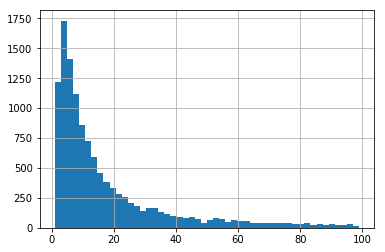

In [6]:
df[df < 100].hist(bins = 50)

#### Age Distribution

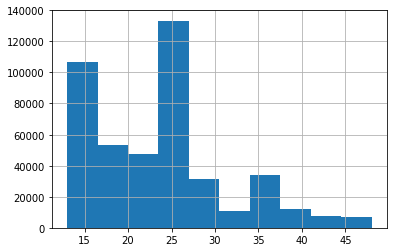

In [7]:
train_data.age.hist()

In [8]:
train_data.age.value_counts().sort_index()

13     9597
14    19615
15    27595
16    49818
17    53315
23    47195
24    54102
25    43920
26    35244
27    31448
33    10713
34     7896
35    10398
36     8935
37     6484
38     4298
39     3505
40     4194
41     2801
42     1262
43     2049
44     1597
45     3065
46     1157
47     1568
48     1190
Name: age, dtype: int64

### Proportion of each topic

In [9]:
all_topics = 100 * train_data.topic.value_counts()/sum(train_data.topic.value_counts())
print("Total topics: ",len(all_topics))
all_topics

Total topics:  40


indUnk                     35.989399
Student                    23.195270
Technology                  6.399209
Arts                        5.488745
Education                   4.190662
Communications-Media        2.978818
Non-Profit                  2.039909
Internet                    2.001305
Engineering                 1.611654
Publishing                  1.267380
Law                         1.242096
Science                     1.100774
Consulting                  1.024921
Government                  0.890823
Religion                    0.782462
BusinessServices            0.779753
Marketing                   0.706608
Fashion                     0.621951
Chemicals                   0.605019
Museums-Libraries           0.595086
Sports-Recreation           0.569576
Advertising                 0.564835
Telecommunications          0.556257
HumanResources              0.513363
Banking                     0.496432
Accounting                  0.493271
Military                    0.405228
R

In [10]:
#In fact the top 8 of 40 topics contribute to 80% of the posts
all_topics[0:7].sum()

80.28201128316037

#### Sign Distribution

In [11]:
all_signs = 100 * train_data.sign.value_counts()/sum(train_data.sign.value_counts())
print("Total signs: ",len(all_signs))
all_signs

Total signs:  12


Taurus         9.493161
Libra          9.275760
Virgo          9.238511
Scorpio        8.702346
Cancer         8.602112
Leo            8.309761
Aries          8.288314
Aquarius       8.044501
Sagittarius    7.831841
Pisces         7.415100
Gemini         7.411713
Capricorn      7.386881
Name: sign, dtype: float64

#### Gender Distribution

In [12]:
100 * train_data.gender.value_counts()/sum(train_data.gender.value_counts())

female    51.435679
male      48.564321
Name: gender, dtype: float64

#### Date distribution

#### Year distribution

In [13]:
year_counts = train_data.date.str.split(",").apply(lambda x:x[2]).value_counts()
100 * year_counts/sum(year_counts)

2004    81.509207
2003    14.751863
2002     2.992589
2001     0.625111
2000     0.104975
1999     0.007224
         0.005418
2006     0.002709
2005     0.000903
Name: date, dtype: float64

#### Checking the cases with no year field

In [14]:
train_data[train_data.date.str.split(",").apply(lambda x:x[2]) == ""]['user.id'].unique()

array([2986], dtype=int64)

It is just one user without the year information. He can be removed from the dataset

In [15]:
#Total number of users
len(train_data['user.id'].unique())

12880

In [16]:
#Number of users with year other than 2004
len(train_data[train_data.date.str.split(",").apply(lambda x:x[2]) != '2004']['user.id'].unique())

968

#### Checking if a user has more than one age

In [17]:
Distinct_age = train_data.groupby(['user.id'])['age'].agg({"Distinct_age": pd.Series.nunique})

C:\Users\arvra\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [18]:
#All the users have only one age
Distinct_age['Distinct_age'].value_counts()

1    12880
Name: Distinct_age, dtype: int64

#### Topics per user

In [19]:
Distinct_topics_per_user = train_data.groupby(['user.id'])['topic'].agg({"Distinct_topic": pd.Series.nunique})

C:\Users\arvra\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [20]:
Distinct_topics_per_user['Distinct_topic'].value_counts()

1    12880
Name: Distinct_topic, dtype: int64

#### Checking if there are any duplicate values

In [21]:
print(train_data.shape)
train_data = train_data.drop_duplicates()
print(train_data.shape)

(442961, 8)
(442961, 8)


### Grouping by user to get text for each user

In [4]:
#train_user_agg.text[1]

In [23]:
overall_data = pd.concat([train_data,test_data],axis = 0)

In [24]:
train_user_text = overall_data.groupby(['user.id'])['text'].apply(' '.join)
train_user_age = train_data.groupby(['user.id'])['age'].max()
train_user_agg = pd.concat([train_user_text,train_user_age], axis = 1)

In [25]:
train_user_agg.head()

,text,age
user.id,,
1,Doritos Fuel of Space urlLink : Ian My...,17.0
2,I finally saw Nathan's tattoo tonig...,NaN
3,"Yeah, I set up this blog so Heather w...",16.0
4,Not too much exciting has happened ...,17.0
5,European Pilgrimage For High sch...,47.0


In [26]:
train_user_agg['Upper_character'] = train_user_agg.text.apply(lambda x: len([each for each in list(x) if each.isupper()]))
print("Completed Upper")
train_user_agg['Lower_character'] = train_user_agg.text.apply(lambda x: len([each for each in list(x) if each.islower()]))
print("Completed Lower")
train_user_agg['Alphabets'] = train_user_agg.text.apply(lambda x: len([each for each in list(x) if each.isalpha()]))
print("Completed Alphabet")
train_user_agg['Numeric'] = train_user_agg.text.apply(lambda x: len([each for each in list(x) if each.isnumeric()]))
print("Completed Numeric")
train_user_agg['Punctuation'] = train_user_agg.text.apply(lambda x: len([each for each in list(x) if each  in punctuation]))
print("Completed Punctuation")

Completed Upper
Completed Lower
Completed Alphabet
Completed Numeric
Completed Punctuation


In [27]:
train_user_agg['Printable'] =  train_user_agg.text.apply(lambda x: len([each for each in list(x) if each.isprintable()]))
print("Completed Printable")

train_user_agg['Vowel'] =  train_user_agg.text.apply(lambda x: len([each for each in list(x) if \
                                                                    each.lower() in ['a','e','i','o','u']]))
print("Completed Vowel")

train_user_agg['Consonent'] =  train_user_agg.text.apply(lambda x: len([each for each in list(x) if \
                                                                    each.lower() not in ['a','e','i','o','u']]))
print("Completed Consonent")

Completed Printable
Completed Vowel
Completed Consonent


In [28]:
train_user_agg['All_Characters'] =  train_user_agg.text.apply(lambda x: len(list(x)))

#### Checking for the number of stop words

In [29]:
stop_words_en = set(stopwords.words('english'))

In [30]:
train_user_agg['Stop words'] =  train_user_agg.text.apply(lambda x: len([each for each in x.split(" ") if \
                                                                    each in stop_words_en ]))
print("Completed Stopwords")

Completed Stopwords


#### Creating additional features

In [31]:
train_user_agg['Upper_ratio'] = train_user_agg.Upper_character/train_user_agg.All_Characters
train_user_agg['Lower_ratio'] = train_user_agg.Lower_character/train_user_agg.All_Characters
train_user_agg['Number_ratio'] = train_user_agg.Numeric/train_user_agg.All_Characters
train_user_agg['Vowel_ratio'] = train_user_agg.Vowel/train_user_agg.All_Characters
train_user_agg['Consonent_ratio'] = train_user_agg.Consonent/train_user_agg.All_Characters
train_user_agg['Punctuation_ratio'] = train_user_agg.Punctuation/train_user_agg.All_Characters

In [32]:
train_user_agg.shape

(19320, 18)

In [33]:
#pd.DataFrame.to_csv(train_user_agg,"Data with meta text.csv")

In [9]:
train_user_agg = pd.read_excel("Data with meta text.xlsx")

FileNotFoundError: [Errno 2] No such file or directory: 'Data with meta text.xlsx'

### Creating data without any text

In [38]:
overall_data['text_len'] = overall_data.text.apply(lambda x: len(x))

In [39]:
train_data_no_text = overall_data
train_data_no_text = train_data_no_text.drop(['post.id','text','date'],axis = 1)

train_data_no_text_grp =  train_data_no_text.groupby(['user.id']).max()

In [40]:
train_data_no_text_grp = train_data_no_text_grp.rename(columns = {'text_len':'max_text'})
train_data_no_text_sum =  train_data_no_text.groupby(['user.id'])['text_len'].sum()

In [42]:
train_data_no_text_grp = pd.concat([train_data_no_text_grp,train_data_no_text_sum],axis = 1)

### Seeing relation between text related features and age

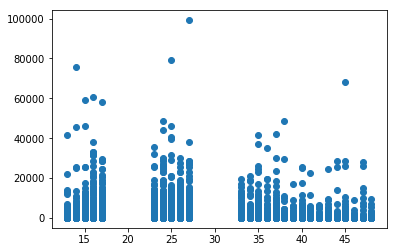

In [395]:
matplotlib.pyplot.scatter(train_user_agg.age,train_user_agg.Upper_character)

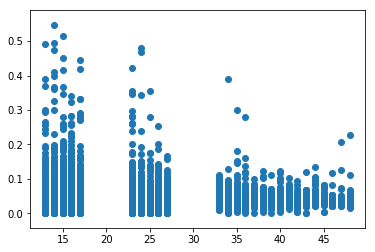

In [392]:
matplotlib.pyplot.scatter(train_user_agg.age,train_user_agg.Upper_character/train_user_agg.Alphabets)

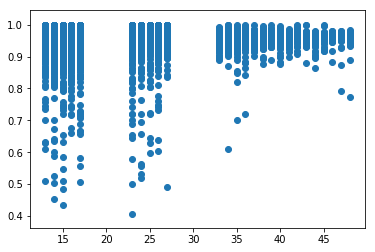

In [393]:
matplotlib.pyplot.scatter(train_user_agg.age,train_user_agg.Lower_character/train_user_agg.Alphabets)

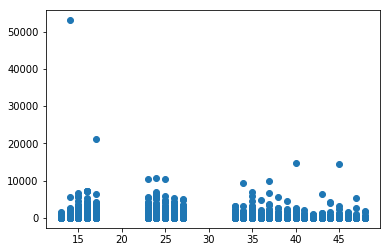

In [397]:
matplotlib.pyplot.scatter(train_user_agg.age,train_user_agg.Numeric)

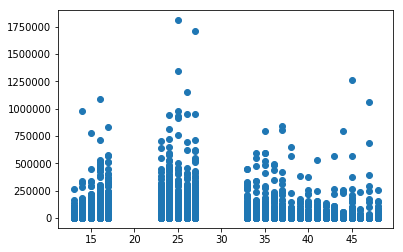

In [399]:
matplotlib.pyplot.scatter(train_user_agg.age,train_user_agg.Alphabets)

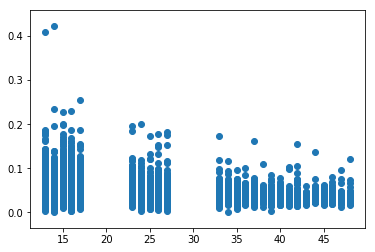

In [447]:
matplotlib.pyplot.scatter(train_user_agg.age,train_user_agg.Punctuation_ratio)

### Combining non-text and meta-text information

In [451]:
#train_user_agg.head()

In [46]:
train_data_text_grp = pd.concat([train_data_no_text_grp,train_user_agg],axis = 1)
train_data_text_grp.shape

(19320, 24)

In [47]:
one_hot_data = pd.get_dummies(train_data_text_grp)

In [48]:
#Separating into train and test
test_data_one_hot = one_hot_data[one_hot_data.age.isnull()]
train_data_one_hot = one_hot_data[~one_hot_data.age.isnull()]


KeyboardInterrupt



In [ ]:
one_hot_data = None

In [ ]:
#Storing train and test dataset
pd.DataFrame.to_csv(train_data_one_hot,"train_one_hot.csv")
pd.DataFrame.to_csv(test_data_one_hot,"test_one_hot.csv")

#### Word Vectorizer

In [274]:
train_user_agg_list = train_user_agg.text.tolist()

In [289]:
train_user_agg_list_2 = [each.strip().replace('  ',' ') for each in train_user_agg_list]

In [291]:
len(train_user_agg_list_2)

12880

In [280]:
train_vectorizer = CountVectorizer(train_user_agg_list, min_df = 200,
                                   lowercase = False,tokenizer = word_tokenize,max_features=1000)

In [335]:
#train_vectors = train_vectorizer.fit_transform(train_user_agg_list)

In [277]:
train_vectors.shape

(12880, 11909)

### Using non-text data for prediction

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X = train_data_one_hot.drop(['age'],axis = 1), y = train_data_one_hot.age)

In [ ]:
predict_age = linear_model.predict(train_data_one_hot.drop(['age'],axis = 1))

In [ ]:
np.sum((predict_age - train_data_one_hot.age) ** 2)

### Prediction on the test dataset

In [ ]:
test_predict_age = linear_model.predict(test_data_one_hot.drop(['age'],axis = 1))

In [ ]:
Test_age_index = pd.DataFrame({'Index': test_data_one_hot.index,'Age':test_predict_age})

In [ ]:
Test_age_index.columns

In [ ]:
test_data.columns

In [ ]:
test_age_final = pd.merge(test_data,Test_age_index,how = 'left',left_on =  'user.id', right_on='Index')

In [ ]:
submission_test = test_age_final.loc[:,['user.id','Age']]
submission_test = submission_test.drop_duplicates()

In [ ]:
pd.DataFrame.to_csv(submission_test,"Submission_test.csv",index = False)

In [ ]:
submission_test.Age.astype('int').value_counts().sort_index()